# Entry G12a notebook: Degree Comparison

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('once')

from neo4j import GraphDatabase

In [110]:
uri = "bolt://localhost:7687"

driver = GraphDatabase.driver(uri, auth=('neo4j', 'password'))

uni_session = driver.session(database="unimodal")
bi_session = driver.session(database="bimodal")
mix_session = driver.session(database="mixmodal")

## Degree Count

### Unimodal Model

In [143]:
uni_session.run('''MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as count''').data()

[{'rel_type': 'KNOWS', 'count': 171644}]

### Bimodal Model

In [91]:
bi_session.run('''MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as count''').data()

[{'rel_type': 'APPEARS_IN', 'count': 96104}]

### Mixed Model

In [142]:
mix_session.run('''MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as count''').data()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'rel_type': 'APPEARS_IN', 'count': 96104},
 {'rel_type': 'KNOWS', 'count': 171613}]

## Degree Summary Statistics

### Unimodal Model

#### Pattern match

In [111]:
uni_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()

[{'degree_min': 0,
  'degree_max': 1919,
  'degree_avg': 53.31,
  'degree_stdev': 116.63}]

#### `apoc` function.

In [9]:
uni_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev''').data()

[{'degree_min': 0,
  'degree_max': 1919,
  'degree_avg': 53.31,
  'degree_stdev': 116.63}]

#### `gds` function

In [11]:
uni_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
  KNOWS: {
  type: 'KNOWS',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()

[{'degree_min': 0.0,
  'degree_max': 1919.0,
  'degree_avg': 53.31,
  'degree_stdev': 116.63}]

#### `size` function

In [97]:
uni_session.run('''MATCH (h)
WITH h.name as hero, size((h)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()

[{'degree_min': 0,
  'degree_max': 1919,
  'degree_avg': 53.31,
  'degree_stdev': 116.63}]

### Bimodal Model

#### Pattern match

To provide consistency between the pattern match option and the `gds` function, I'm including three ways to pull the degree by including (or excluding) information about the direction of the relationship.

- Outgoing relationship
  - Due to the relationship direction in our data, the query only returns c2 results when the start node is a Hero node
  - (:Hero)-[]->(:Comic)
- Incoming relationship
  - Due to the relationship direction in our data, the query only returns c2 results when the start node is a Comic node
  - (:Comic)<-[]-(:Hero)
- Undirected relationship
  - Because there is no constraint regarding the direction of the relationship, the query returns results for c2 regardless of node label
  - (:Hero)-[]-(:Comic)
  - (:Comic)-[]-(:Hero)
  
*Note*, if we fail to include the label in the first `MATCH` statement of the outgoing and incoming relationship queries, all nodes of the other label will return a degree of 0, which effects our average and standard deviation.

**Outgoing relationship**

In [137]:
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'incorrect'}).merge(
pd.DataFrame(bi_session.run('''MATCH (c1:Hero)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'correct'}), left_index=True, right_index=True)

,incorrect,correct
degree_min,0.00,1.00
degree_max,1577.00,1577.00
degree_avg,5.03,14.93
degree_stdev,35.14,59.27


**Incoming relationship**

In [141]:
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'incorrect'}).merge(
pd.DataFrame(bi_session.run('''MATCH (c1:Comic)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'correct'}), left_index=True, right_index=True)

,incorrect,correct
degree_min,0.00,1.00
degree_max,111.00,111.00
degree_avg,5.03,7.60
degree_stdev,6.35,6.44


**Undirected relationship**

In [116]:
bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()

[{'degree_min': 1,
  'degree_max': 1577,
  'degree_avg': 10.07,
  'degree_stdev': 34.99}]

**Outgoing, incoming, and undirected relationship combined**

In [117]:
pd.DataFrame(bi_session.run('''MATCH (c1:Hero)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'outgoing (hero to comic)'}).merge(
pd.DataFrame(bi_session.run('''MATCH (c1:Comic)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'incoming (comic from hero)'}), left_index=True, right_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'undirected (all)'}), left_index=True, right_index=True)

,outgoing (hero to comic),incoming (comic from hero),undirected (all)
degree_min,1.00,1.00,1.00
degree_max,1577.00,111.00,1577.00
degree_avg,14.93,7.60,10.07
degree_stdev,59.27,6.44,34.99


#### `apoc` function.

In [10]:
bi_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev''').data()

[{'degree_min': 1,
  'degree_max': 1577,
  'degree_avg': 10.07,
  'degree_stdev': 34.99}]

#### `gds` function

Relationship orientation options:

- `NATURAL`
  - Follows the indicated relationship direction
  - Ex: (:Hero)-[:APPEARS_IN]->(:Comic)
  - For the bimodal model, this will tell us the number of comics that a hero appears in
- `REVERSE` 
  - Reverses the indicated relationship direction
  - Ex: (:Hero)<-[:APPEARS_IN]-(:Comic)
  - For the bimodal model, this will tell us the number of heros in any given comic
- `UNDIRECTED`
  - Uses relationship regardless of direction
  - Ex: (:Hero)-[:APPEARS_IN]-(:Comic)
  - This will include both the number of comics that a hero appears in and the number of heros in any given comic

In [122]:
pd.DataFrame(bi_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'NATURAL'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()).transpose().rename(columns = {0:'NATURAL'}).merge(
    pd.DataFrame(bi_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'REVERSE'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()).transpose().rename(columns = {0:'REVERSE'}), left_index=True, right_index=True).merge(
    pd.DataFrame(bi_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()).transpose().rename(columns = {0:'UNDIRECTED'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,NATURAL,REVERSE,UNDIRECTED
degree_min,0.00,0.00,1.00
degree_max,1577.00,111.00,1577.00
degree_avg,5.03,5.03,10.07
degree_stdev,35.14,6.35,34.99


#### `size` function

In [123]:
pd.DataFrame(bi_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'outgoing (hero to comic)'}).merge(
pd.DataFrame(bi_session.run('''MATCH (c:Comic)
WITH c.name as comic, size((c)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'incoming (comic from hero)'}), left_index=True, right_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (n)
WITH n.name as name, size((n)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'undirected (all)'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,outgoing (hero to comic),incoming (comic from hero),undirected (all)
degree_min,1.00,1.00,1.00
degree_max,1577.00,111.00,1577.00
degree_avg,14.93,7.60,10.07
degree_stdev,59.27,6.44,34.99


### Mixed Model

#### Pattern match

In [128]:
pd.DataFrame(mix_session.run('''MATCH (c1)-[:APPEARS_IN]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'APPEARS_IN undirected'}).merge(
pd.DataFrame(mix_session.run('''MATCH (c1:Hero)-[:APPEARS_IN]->(c2:Comic)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to comic'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (c1:Comic)<-[:APPEARS_IN]-(c2:Hero)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'comic to hero'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (c1)-[:KNOWS]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'KNOWS undirected (hero to hero)'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'all undirected'}), left_index=True, right_index=True)

,APPEARS_IN undirected,hero to comic,comic to hero,KNOWS undirected (hero to hero),all undirected
degree_min,1.00,1.00,1.00,1.00,1.00
degree_max,1577.00,1577.00,111.00,1919.00,3331.00
degree_avg,10.07,14.93,7.60,53.45,28.05
degree_stdev,34.99,59.27,6.44,116.75,104.41


### `apoc.node.degree` function

In [147]:
pd.DataFrame(mix_session.run('''MATCH (n:Hero)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to any'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Hero)
RETURN min(apoc.node.degree(n, "APPEARS_IN")) as degree_min,
max(apoc.node.degree(n, "APPEARS_IN")) as degree_max,
round(avg(apoc.node.degree(n, "APPEARS_IN"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "APPEARS_IN"))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to comic'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Hero)-[:KNOWS]-(:Hero)
RETURN min(apoc.node.degree(n, "KNOWS")) as degree_min,
max(apoc.node.degree(n, "KNOWS")) as degree_max,
round(avg(apoc.node.degree(n, "KNOWS"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "KNOWS"))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to hero'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Comic)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'comic to any'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'all undirected'}), left_index=True, right_index=True)

,hero to any,hero to comic,hero to hero,comic to any,all undirected
degree_min,1.00,1.00,1.00,1.00,1.00
degree_max,3331.00,1577.00,1919.00,111.00,3331.00
degree_avg,68.23,14.93,308.41,7.60,28.05
degree_stdev,172.65,59.27,393.13,6.44,104.41


### `gds.alpha.degree.stream` function

In [133]:
pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'APPEARS_IN undirected'}).merge(
pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'NATURAL'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to comic'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'REVERSE'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'comic to hero'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'KNOWS',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'KNOWS undirected (hero to hero)'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: ['KNOWS', 'APPEARS_IN']
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS name, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'all undirected'}), left_index=True, right_index=True)

,APPEARS_IN undirected,hero to comic,comic to hero,KNOWS undirected (hero to hero),all undirected
degree_min,1.00,0.00,0.00,0.00,0.00
degree_max,1577.00,1577.00,111.00,1919.00,3004.00
degree_avg,10.07,5.03,5.03,17.98,14.02
degree_stdev,34.99,35.14,6.35,72.26,71.98


### `size` function

In [134]:
pd.DataFrame(mix_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)--(:Comic)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to comic'}).merge(
pd.DataFrame(mix_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)--(:Hero)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'hero to hero'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (c:Comic)
WITH c.name as comic, size((c)--(:Hero)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'comic to hero'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n)
WITH n.name as name, size((n)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'all undirected'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero to comic,hero to hero,comic to hero,all undirected
degree_min,1.00,0.00,1.00,1.00
degree_max,1577.00,1919.00,111.00,3331.00
degree_avg,14.93,53.30,7.60,28.05
degree_stdev,59.27,116.62,6.44,104.41


## Degree Distribution

In [19]:
uni_degree_df = pd.DataFrame(uni_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
  KNOWS: {
  type: 'KNOWS',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS hero, score AS degree
''').values(), columns=['hero', 'degree'])
uni_degree_df.head()

,hero,degree
0,24-HOUR MAN/EMMANUEL,5.0
1,3-D MAN/CHARLES CHAN,122.0
2,4-D MAN/MERCURIO,72.0
3,8-BALL/,14.0
4,"ABBOTT, JACK",8.0


In [20]:
bi_degree_df = pd.DataFrame(bi_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score AS degree, labels(gds.util.asNode(nodeId))[0] as type
''').values(), columns=['hero', 'degree', 'type'])
bi_degree_df.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree,type
0,24-HOUR MAN/EMMANUEL,1.0,Hero
1,AA2 35,6.0,Comic
2,3-D MAN/CHARLES CHAN,9.0,Hero
3,AVF 4,11.0,Comic
4,AVF 5,11.0,Comic


In [102]:
mixed_all = pd.DataFrame(mix_session.run('''MATCH (n)
RETURN n.name as name, size((n)--()) as degree''').data())
mixed_all.head()

,name,degree
0,24-HOUR MAN/EMMANUEL,6
1,AA2 35,6
2,3-D MAN/CHARLES CHAN,131
3,AVF 4,11
4,AVF 5,11


In [104]:
mixed_hero2hero = pd.DataFrame(mix_session.run('''MATCH (h:Hero)
RETURN h.name as hero, size((h)--(:Hero)) as degree''').data())
mixed_hero2hero.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree
0,24-HOUR MAN/EMMANUEL,5
1,3-D MAN/CHARLES CHAN,122
2,4-D MAN/MERCURIO,72
3,8-BALL/,14
4,"ABBOTT, JACK",8


In [103]:
mixed_hero2comic= pd.DataFrame(mix_session.run('''MATCH (h:Hero)
RETURN h.name as hero, size((h)--(:Comic)) as degree''').data())
mixed_hero2comic.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree
0,24-HOUR MAN/EMMANUEL,1
1,3-D MAN/CHARLES CHAN,9
2,4-D MAN/MERCURIO,9
3,8-BALL/,3
4,"ABBOTT, JACK",1


In [105]:
mixed_comic2hero= pd.DataFrame(mix_session.run('''MATCH (c:Comic)
RETURN c.name as comic, size((c)--(:Hero)) as degree''').data())
mixed_comic2hero.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comic,degree
0,AA2 35,6
1,AVF 4,11
2,AVF 5,11
3,COC 1,111
4,H2 251,8


### Unimodal Model

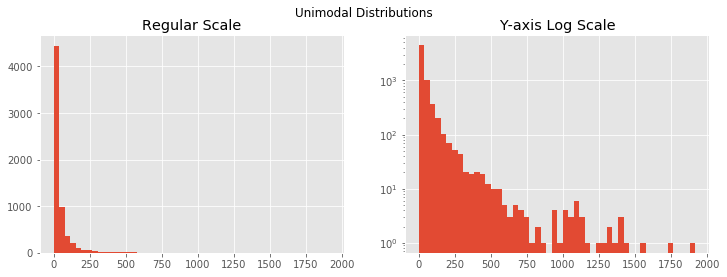

In [46]:
uni_fig, (uni_ax1, uni_ax2) = plt.subplots(1, 2, figsize=(12,4))
uni_fig.suptitle("Unimodal Distributions")
uni_ax1.hist(uni_degree_df['degree'], bins=50)
uni_ax1.set_title('Regular Scale')
uni_ax2.hist(uni_degree_df['degree'], bins=50)
uni_ax2.set_yscale('log')
uni_ax2.set_title('Y-axis Log Scale')
plt.show()

### Bimodal Model

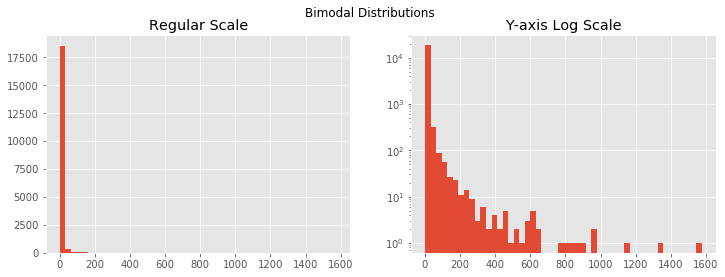

In [146]:
bi_fig, (bi_ax1, bi_ax2) = plt.subplots(1, 2, figsize=(12,4))
bi_fig.suptitle("Bimodal Distributions")
bi_ax1.hist(bi_degree_df['degree'], bins=50)
bi_ax1.set_title('Regular Scale')
bi_ax2.hist(bi_degree_df['degree'], bins=50)
bi_ax2.set_yscale('log')
bi_ax2.set_title('Y-axis Log Scale')
plt.show()

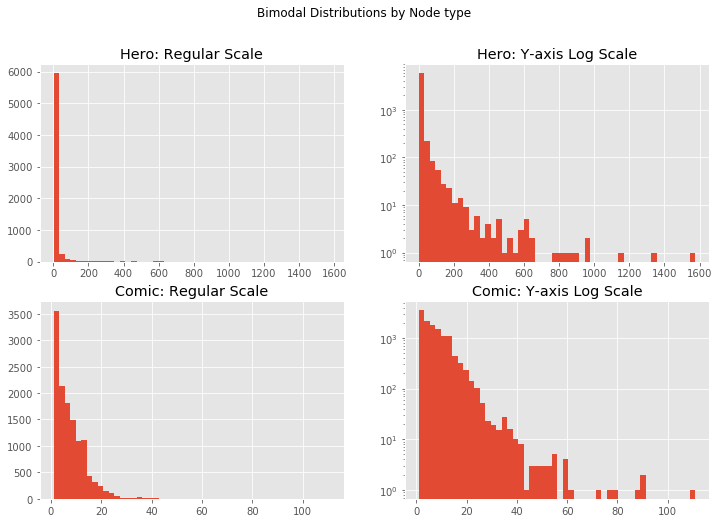

In [51]:
bi_fig2, bi_axes = plt.subplots(2, 2, figsize=(12,8))
bi_fig2.suptitle("Bimodal Distributions by Node type")
bi_axes[0,0].hist(bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'], bins=50)
bi_axes[0,0].set_title('Hero: Regular Scale')
bi_axes[0,1].hist(bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'], bins=50)
bi_axes[0,1].set_yscale('log')
bi_axes[0,1].set_title('Hero: Y-axis Log Scale')
bi_axes[1,0].hist(bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'], bins=50)
bi_axes[1,0].set_title('Comic: Regular Scale')
bi_axes[1,1].hist(bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'], bins=50)
bi_axes[1,1].set_yscale('log')
bi_axes[1,1].set_title('Comic: Y-axis Log Scale')
plt.show()

### Mixed Model

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


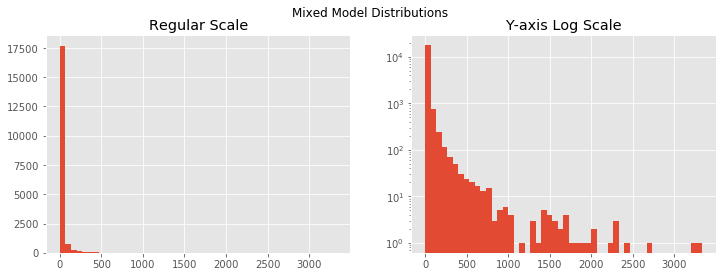

In [106]:
mix_fig, (mix_ax1, mix_ax2) = plt.subplots(1, 2, figsize=(12,4))
mix_fig.suptitle("Mixed Model Distributions")
mix_ax1.hist(mixed_all['degree'], bins=50)
mix_ax1.set_title('Regular Scale')
mix_ax2.hist(mixed_all['degree'], bins=50)
mix_ax2.set_yscale('log')
mix_ax2.set_title('Y-axis Log Scale')
plt.show()

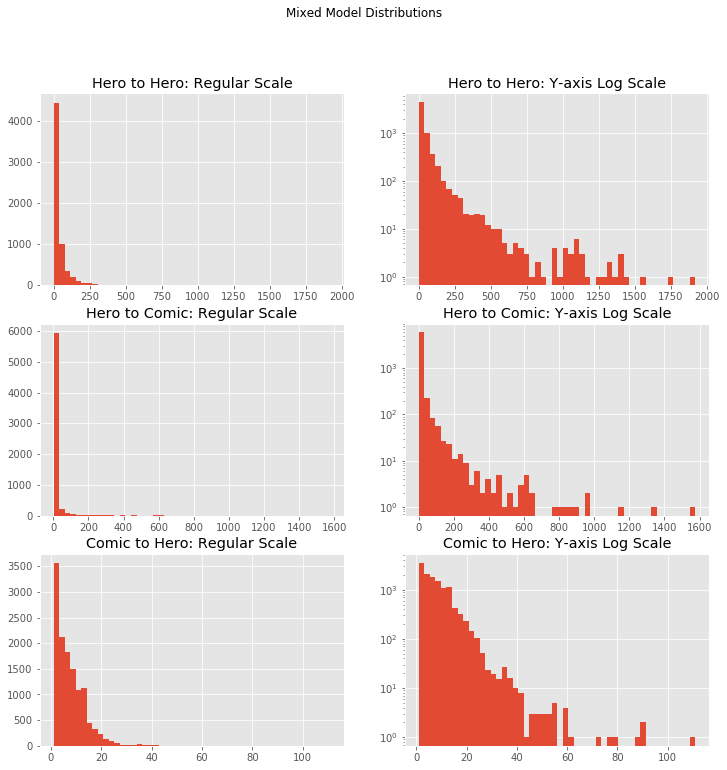

In [108]:
mix_fig2, mix_axes = plt.subplots(3, 2, figsize=(12,12))
mix_fig2.suptitle("Mixed Model Distributions")
mix_axes[0,0].hist(mixed_hero2hero['degree'], bins=50)
mix_axes[0,0].set_title('Hero to Hero: Regular Scale')
mix_axes[0,1].hist(mixed_hero2hero['degree'], bins=50)
mix_axes[0,1].set_yscale('log')
mix_axes[0,1].set_title('Hero to Hero: Y-axis Log Scale')
mix_axes[1,0].hist(mixed_hero2comic['degree'], bins=50)
mix_axes[1,0].set_title('Hero to Comic: Regular Scale')
mix_axes[1,1].hist(mixed_hero2comic['degree'], bins=50)
mix_axes[1,1].set_yscale('log')
mix_axes[1,1].set_title('Hero to Comic: Y-axis Log Scale')
mix_axes[2,0].hist(mixed_comic2hero['degree'], bins=50)
mix_axes[2,0].set_title('Comic to Hero: Regular Scale')
mix_axes[2,1].hist(mixed_comic2hero['degree'], bins=50)
mix_axes[2,1].set_yscale('log')
mix_axes[2,1].set_title('Comic to Hero: Y-axis Log Scale')
plt.show()